In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [4]:
df_train = pd.read_csv('Data/train.csv')
df_test = pd.read_csv('Data/test.csv')

<h1>Explore data</h1>

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71236 entries, 0 to 71235
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   encounter_id                           71236 non-null  int64 
 1   country                                71236 non-null  object
 2   patient_id                             71236 non-null  int64 
 3   race                                   67682 non-null  object
 4   gender                                 71236 non-null  object
 5   age                                    67679 non-null  object
 6   weight                                 71236 non-null  object
 7   payer_code                             71236 non-null  object
 8   outpatient_visits_in_previous_year     71236 non-null  int64 
 9   emergency_visits_in_previous_year      71236 non-null  int64 
 10  inpatient_visits_in_previous_year      71236 non-null  int64 
 11  admission_type 

In [6]:
df_train.replace('?', np.nan, inplace = True)
df_train.replace('Not Mapped', np.nan, inplace = True)

In [7]:
#repeat for test data
df_test.replace('?', np.nan, inplace = True)
df_test.replace('Not Mapped', np.nan, inplace = True)

In [8]:
#Get the amount of empty values
df_train.isna().sum()

encounter_id                                 0
country                                      0
patient_id                                   0
race                                      5070
gender                                       0
age                                       3557
weight                                   68990
payer_code                               28201
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                            3920
medical_specialty                        34922
average_pulse_bpm                            0
discharge_disposition                     3269
admission_source                          4718
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                           16
secondary_dia

In [9]:
df_train['country'].unique().sum()
#there is only one country, so we will drop the country column
df_train = df_train.drop('country', axis=1)

In [10]:
#repeat for test data
df_test['country'].unique().sum()
#there is only one country, so we will drop the country column
#df_test = df_train.drop('country', axis=1)

'USA'

In [11]:
df_train.head(2)

,encounter_id,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
0,533253,70110,Caucasian,Female,[70-80),NaN,NaN,0,0,2,...,276,466,8,NaN,NaN,No,No,[],No,>30 days
1,426224,29775006,AfricanAmerican,Male,[50-60),NaN,NaN,0,0,0,...,785,162,9,NaN,NaN,No,Yes,['insulin'],No,No


In [12]:
#making target variable numerical
df_train['readmitted_binary'] = df_train['readmitted_binary'].replace({'Yes': 1, 'No': 0}).astype(int)
#binary encoding of gender
df_train['gender'] = df_train['gender'].replace({'Female': 1, 'Male': 0, 'Unknown/Invalid': np.nan}).astype(float)

#one hot encoding for race
encoder_race = OneHotEncoder(sparse_output = False, drop='first')
one_hot_encoded = encoder_race.fit_transform(df_train['race'].values.reshape(-1, 1))

#concatenate the one-hot encoded df with df_test
df_train = pd.concat([df_train, pd.DataFrame(one_hot_encoded, columns=encoder_race.get_feature_names_out(['race']))], axis=1)

In [13]:
df_test.head()

,encounter_id,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,...,number_of_medications,primary_diagnosis,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication
0,499502,USA,103232799,Caucasian,Male,[80-90),NaN,HM,0,0,...,14,491,414,250,6,NaN,NaN,No,Yes,['metformin']
1,447319,USA,93395304,Caucasian,Male,[20-30),NaN,HM,0,0,...,7,250.13,70,794,7,>300,NaN,No,No,[]
2,309126,USA,6281586,AfricanAmerican,Male,[30-40),NaN,NaN,0,0,...,12,786,250.6,536,6,NaN,NaN,No,Yes,['insulin']
3,181183,USA,67381308,Caucasian,Male,[50-60),NaN,BC,0,0,...,16,820,873,E884,9,NaN,NaN,Ch,Yes,"['metformin', 'glyburide', 'insulin']"
4,359339,USA,71670204,Caucasian,Male,[60-70),NaN,NaN,0,0,...,10,599,427,414,9,NaN,NaN,No,Yes,['metformin']


In [14]:
#repeat for test data 

#binary encoding of gender
df_test['gender'] = df_test['gender'].replace({'Female': 1, 'Male': 0, 'Unknown/Invalid': np.nan}).astype(float)

#one hot encoding for race
encoder_race = OneHotEncoder(sparse_output = False, drop='first')
one_hot_encoded = encoder_race.fit_transform(df_test['race'].values.reshape(-1, 1))

#concatenate the one-hot encoded df with df_test
df_test = pd.concat([df_test, pd.DataFrame(one_hot_encoded, columns=encoder_race.get_feature_names_out(['race']))], axis=1)

In [15]:
#one hot encoding for payer_code
encoder_payer_code = OneHotEncoder(sparse_output= False, drop='first')
one_hot_encoded = encoder_payer_code.fit_transform(df_train['payer_code'].values.reshape(-1,1))

df_train = pd.concat([df_train, pd.DataFrame(one_hot_encoded, columns=encoder_payer_code.get_feature_names_out(['payer_code']))], axis = 1)

In [16]:
#repeat for test data 
#one hot encoding for payer_code
encoder_payer_code = OneHotEncoder(sparse_output= False, drop='first')
one_hot_encoded = encoder_payer_code.fit_transform(df_test['payer_code'].values.reshape(-1,1))

df_test = pd.concat([df_test, pd.DataFrame(one_hot_encoded, columns=encoder_payer_code.get_feature_names_out(['payer_code']))], axis = 1)

<h1>Medical Specialty

In [17]:
df_train['medical_specialty'].value_counts()


InternalMedicine                 10292
Emergency/Trauma                  5319
Family/GeneralPractice            5217
Cardiology                        3716
Surgery-General                   2144
                                 ...  
SportsMedicine                       1
Pediatrics-InfectiousDiseases        1
Proctology                           1
Pediatrics-EmergencyMedicine         1
Neurophysiology                      1
Name: medical_specialty, Length: 68, dtype: int64

In [18]:
#half the values are missing for the medical specialty 
df_train['medical_specialty'].isna().mean() 
#i opted to create columns according to relation to target variable, but would it be better to drop the column since half are missing values?

0.49022965916109834

In [19]:
df_train['medical_specialty'].fillna('Not Available', inplace=True)

In [20]:
#repeat for test data
df_test['medical_specialty'].fillna('Not Available', inplace=True)

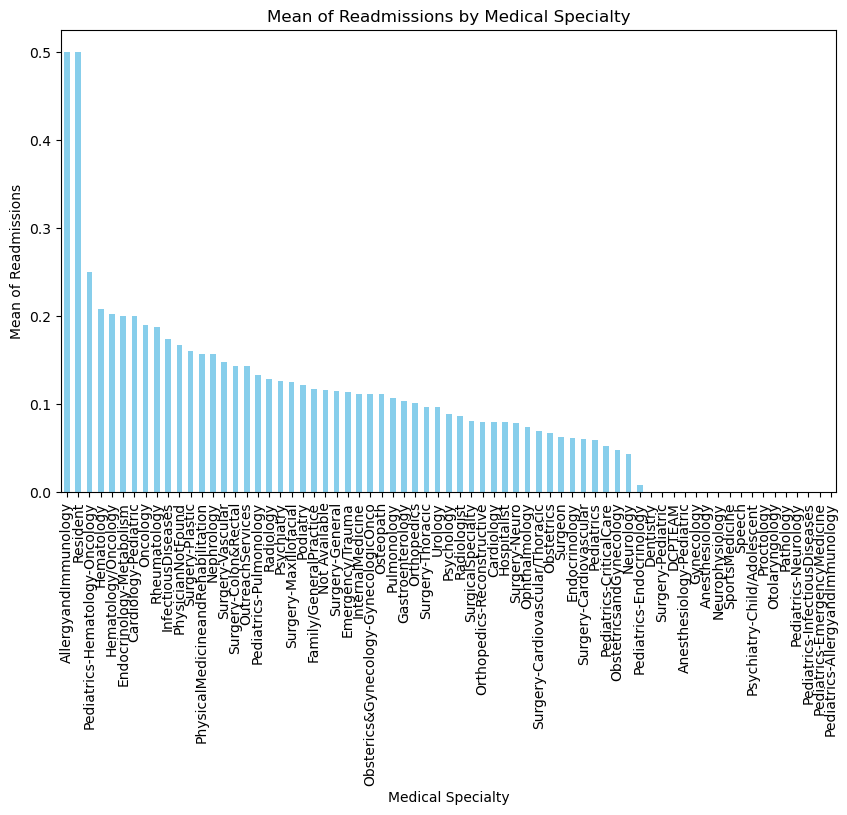

In [21]:
grouped_data = df_train.groupby('medical_specialty')['readmitted_binary'].mean()

import matplotlib.pyplot as plt

# Sort specialties based on mean values
sorted_data = grouped_data.sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(10, 6))
sorted_data.plot(kind='bar', color='skyblue')
plt.title('Mean of Readmissions by Medical Specialty')
plt.ylabel('Mean of Readmissions')
plt.xlabel('Medical Specialty')
plt.show()

In [22]:
pd.set_option('display.max_rows', None)

cnt = df_train[['encounter_id','medical_specialty']].groupby(by = 'medical_specialty').count().sort_values(by = 'encounter_id', ascending=False)
mean = df_train[['readmitted_binary','medical_specialty']].groupby(by = 'medical_specialty').mean().sort_values(by = 'readmitted_binary', ascending=False)
pd.concat([cnt, mean], axis = 1).sort_values(by = 'readmitted_binary', ascending=False)


,encounter_id,readmitted_binary
medical_specialty,,
AllergyandImmunology,6,0.500000
Resident,2,0.500000
Pediatrics-Hematology-Oncology,4,0.250000
Hematology,53,0.207547
Hematology/Oncology,153,0.202614
Cardiology-Pediatric,5,0.200000
Endocrinology-Metabolism,5,0.200000
Oncology,243,0.189300
Rheumatology,16,0.187500


In [23]:

df_train['no_medical_specialty'] = df_train['medical_specialty'].apply(lambda x: 1 if x == 'Not Available' else 0) #most values are here, does this make sense? 

df_train['high_medical_specialty'] = df_train['medical_specialty'].apply(lambda x: 
                                                                      1 if (
                                                                          x == 'AllergyAndImmunology'
                                                                                   or x == 'Resident'
                                                                                   or x == 'Pediatrics-Hematology-Oncology'
                                                                                   or x == 'Hematology'
                                                                                   or x == 'Hematology/Oncology'
                                                                                   or x == 'Cardiology-Pediatric'
                                                                                   or x == 'Oncology'
                                                                                   or x == 'Rheumatology'
                                                                                   or x == 'InfectiousDiseases'
                                                                                   or x == 'PhysicianNotFound'
                                                                                   or x == 'Surgery-Plastic'
                                                                                   or x == 'PhysicalMedicineandRehabilitation'
                                                                                   or x == 'Nephrology'
                                                                                   or x == 'Surgery-Vascular'
                                                                                   or x == 'Surgery-Colon&Rectal'
                                                                                   or x == 'OutreachServices'
                                                                                   ) else 0)

df_train['lower_medical_specialty'] = df_train['medical_specialty'].apply(lambda x: 
                                                                      1 if (x == 'Pediatrics-Pulmonology'
                                                                                   or x == 'Radiology'
                                                                                   or x == 'Psychiatry'
                                                                                   or x == 'Surgery-Maxillofacial'
                                                                                   or x == 'Podiatry'
                                                                                   or x == 'Family/GeneralPractice'
                                                                                   or x == 'Surgery-General'
                                                                                   or x == 'Emergency/Trauma' 
                                                                                   or x == 'InternalMedicine'
                                                                                   or x == 'Pulmonology'
                                                                                   or x == 'Gastroenterology'
                                                                                   or x == 'Orthopedics'
                                                                                   or x == 'Urology'
                                                                                   or x == 'Radiologist'
                                                                                   or x == 'Orthopedics-Reconstructive'
                                                                                   or x == 'Cardiology'
                                                                                   or x == 'Surgery-Neuro'
                                                                                   or x == 'Surgery-Cardiovascular/Thoracic'
                                                                                   or x == 'Pediatrics'
                                                                                   or x == 'ObstetricsandGynecology'
                                                                                   or x == 'Neurology'
                                                                                   ) else 0)       
                                                                                                                                       


df_train['other_medical_specialty'] = df_train['medical_specialty'].apply(lambda x: 
                                                                      1 if (x == 'Pediatrics-Neurology'
                                                                                   or x == 'Gynecology'
                                                                                   or x == 'Anesthesiology-Pediatric'
                                                                                   or x == 'Pathology'
                                                                                   or x == 'Otolaryngology'
                                                                                   or x == 'Pediatrics-Endocrinology' ) else 0)

#try target encoding 
#split into 3 or 4 groups, but we can use a loop. myabe create one for oncology 


In [24]:
#repeat for test data
df_test['allergy_or_resident'] = df_train['medical_specialty'].apply(lambda x: 
                                                                              1 if (x == 'AllergyAndImmunology'
                                                                                   or x == 'Resident')
                                                                              else 0) #highest readmission_binary
                                                                              
df_test['no_medical_specialty'] = df_test['medical_specialty'].apply(lambda x: 1 if x == 'Not Available' else 0) #most values are here, does this make sense? 

df_test['mid_medical_specialty'] = df_test['medical_specialty'].apply(lambda x: 
                                                                      1 if (x == 'Pediatrics-Hematology-Oncology'
                                                                                   or x == 'Hematology'
                                                                                   or x == 'Hematology/Oncology'
                                                                                   or x == 'Cardiology-Pediatric'
                                                                                   or x == 'Oncology'
                                                                                   or x == 'Rheumatology'
                                                                                   or x == 'InfectiousDiseases'
                                                                                   or x == 'PhysicianNotFound'
                                                                                   or x == 'Surgery-Plastic'
                                                                                   or x == 'PhysicalMedicineandRehabilitation'
                                                                                   or x == 'Nephrology'
                                                                                   or x == 'Surgery-Vascular'
                                                                                   or x == 'Surgery-Colon&Rectal'
                                                                                   or x == 'OutreachServices'
                                                                                   ) else 0)

df_test['lower_medical_specialty'] = df_test['medical_specialty'].apply(lambda x: 
                                                                      1 if (x == 'Pediatrics-Pulmonology'
                                                                                   or x == 'Radiology'
                                                                                   or x == 'Psychiatry'
                                                                                   or x == 'Surgery-Maxillofacial'
                                                                                   or x == 'Podiatry'
                                                                                   or x == 'Family/GeneralPractice'
                                                                                   or x == 'Surgery-General'
                                                                                   or x == 'Emergency/Trauma' 
                                                                                   or x == 'InternalMedicine'
                                                                                   or x == 'Pulmonology'
                                                                                   or x == 'Gastroenterology'
                                                                                   or x == 'Orthopedics'
                                                                                   or x == 'Urology'
                                                                                   or x == 'Radiologist'
                                                                                   or x == 'Orthopedics-Reconstructive'
                                                                                   or x == 'Cardiology'
                                                                                   or x == 'Surgery-Neuro'
                                                                                   or x == 'Surgery-Cardiovascular/Thoracic'
                                                                                   or x == 'Pediatrics'
                                                                                   or x == 'ObstetricsandGynecology'
                                                                                   or x == 'Neurology'
                                                                                   ) else 0)       
                                                                                                                                       

df_test['pediatrics_endocrinology'] = df_test['medical_specialty'].apply(lambda x: 
                                                                      1 if x == 'Pediatrics-Endocrinology' else 0) #lowest value, too far from the others

df_test['other_medical_specialty'] = df_test['medical_specialty'].apply(lambda x: 
                                                                      1 if (x == 'Pediatrics-Neurology'
                                                                                   or x == 'Gynecology'
                                                                                   or x == 'Anesthesiology-Pediatric'
                                                                                   or x == 'Pathology'
                                                                                   or x == 'Otolaryngology') else 0) #value as zero


In [25]:
df_train.head()

,encounter_id,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,payer_code_SP,payer_code_UN,payer_code_WC,payer_code_nan,allergy_or_resident,no_medical_specialty,mid_medical_specialty,lower_medical_specialty,pediatrics_endocrinology,other_medical_specialty
0,533253,70110,Caucasian,1.0,[70-80),NaN,NaN,0,0,2,...,0.0,0.0,0.0,1.0,0,0,0,1,0,0
1,426224,29775006,AfricanAmerican,0.0,[50-60),NaN,NaN,0,0,0,...,0.0,0.0,0.0,1.0,0,1,0,0,0,0
2,634063,80729253,Caucasian,1.0,[60-70),NaN,NaN,0,0,1,...,0.0,0.0,0.0,1.0,0,0,0,1,0,0
3,890610,2919042,AfricanAmerican,0.0,[60-70),NaN,MC,0,0,1,...,0.0,0.0,0.0,0.0,0,0,0,1,0,0
4,654194,84871971,Caucasian,1.0,[70-80),NaN,HM,1,0,0,...,0.0,0.0,0.0,0.0,0,1,0,0,0,0


<h1>Average Pulse Bpm

In [26]:
pd.set_option('display.max_rows', None)

cnt = df_train[['encounter_id','average_pulse_bpm']].groupby(by = 'average_pulse_bpm').count().sort_values(by = 'encounter_id', ascending=False)
mean = df_train[['readmitted_binary','average_pulse_bpm']].groupby(by = 'average_pulse_bpm').mean().sort_values(by = 'readmitted_binary', ascending=False)
pd.concat([cnt, mean], axis = 1).sort_values(by = 'readmitted_binary', ascending=False)


,encounter_id,readmitted_binary
average_pulse_bpm,,
135,870,0.136782
68,891,0.133558
91,855,0.132164
70,876,0.131279
92,908,0.131057
122,901,0.129856
107,882,0.129252
125,921,0.127036
137,897,0.124861


In [27]:
pd.isna(df_train['average_pulse_bpm']).value_counts() #no NaNs

False    71236
Name: average_pulse_bpm, dtype: int64

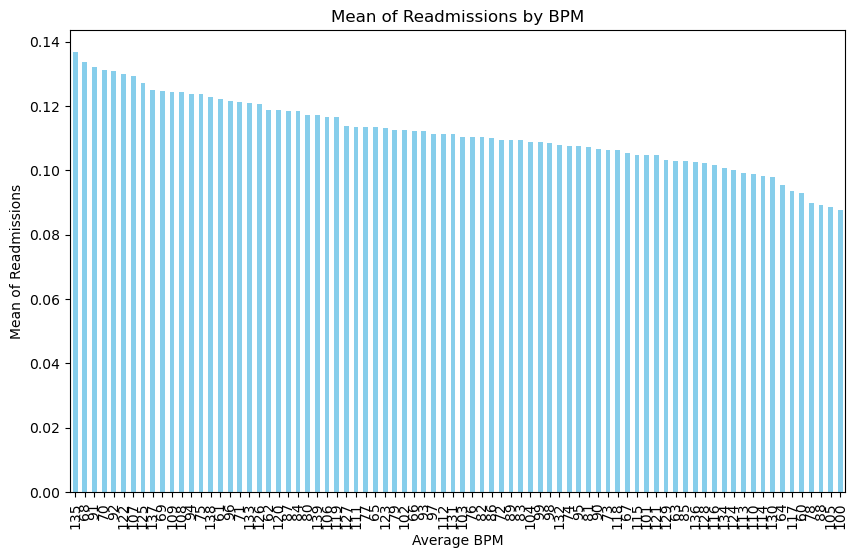

In [28]:
grouped_data = df_train.groupby('average_pulse_bpm')['readmitted_binary'].mean()

# Sort specialties based on mean values
sorted_data = grouped_data.sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(10, 6))
sorted_data.plot(kind='bar', color='skyblue')
plt.title('Mean of Readmissions by BPM')
plt.ylabel('Mean of Readmissions')
plt.xlabel('Average BPM')
plt.show()

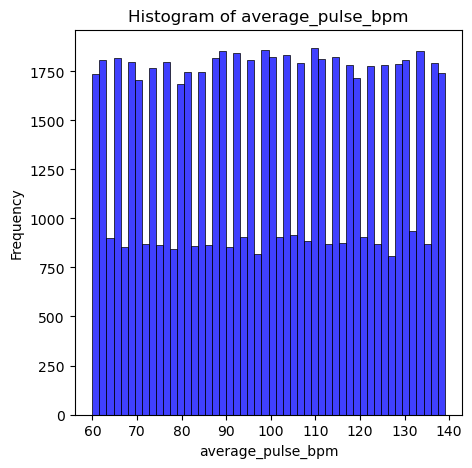

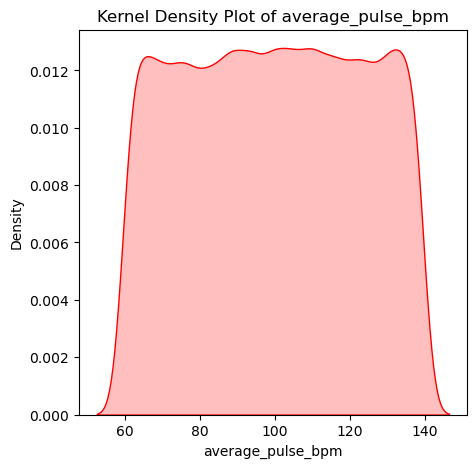

In [29]:
#check the distribution 
import matplotlib.pyplot as plt


plt.figure(figsize=(5, 5))
sns.histplot(df_train['average_pulse_bpm'], bins=50, kde=False, color='blue')
plt.title('Histogram of average_pulse_bpm')
plt.xlabel('average_pulse_bpm')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(5, 5))
sns.kdeplot(df_train['average_pulse_bpm'], color='red', fill=True)
plt.title('Kernel Density Plot of average_pulse_bpm')
plt.xlabel('average_pulse_bpm')
plt.ylabel('Density')
plt.show()


In [30]:
#the distribution does not seem normal, so let's use minmaxscaler
scaler = MinMaxScaler()
df_train['average_pulse_bpm_scaled'] = scaler.fit_transform(df_train[['average_pulse_bpm']])


In [31]:
#repeat for test data
scaler = MinMaxScaler()
df_test['average_pulse_bpm_scaled'] = scaler.fit_transform(df_test[['average_pulse_bpm']])

<h1>Discharge disposition

In [32]:
pd.set_option('display.max_rows', None)

df_train['discharge_disposition'].value_counts()

Discharged to home                                                                                           42256
Discharged/transferred to SNF                                                                                 9780
Discharged/transferred to home with home health service                                                       9005
Discharged/transferred to another short term hospital                                                         1488
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1393
Expired                                                                                                       1135
Discharged/transferred to another type of inpatient care institution                                           822
Discharged/transferred to ICF                                                                                  571
Left AMA                                                                        

In [33]:
pd.set_option('display.max_rows', None)

cnt = df_train[['encounter_id','discharge_disposition']].groupby(by = 'discharge_disposition').count().sort_values(by = 'encounter_id', ascending=False)
mean = df_train[['readmitted_binary','discharge_disposition']].groupby(by = 'discharge_disposition').mean().sort_values(by = 'readmitted_binary', ascending=False)
pd.concat([cnt, mean], axis = 1).sort_values(by = 'readmitted_binary', ascending=False)

,encounter_id,readmitted_binary
discharge_disposition,,
Admitted as an inpatient to this hospital,13,0.538462
Still patient or expected to return for outpatient services,2,0.500000
Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital,98,0.397959
Discharged/transferred within this institution to Medicare approved swing bed,44,0.386364
Discharged/transferred to another rehab fac including rehab units of a hospital .,1393,0.278536
Discharged/transferred to another type of inpatient care institution,822,0.209246
Discharged/transferred to another short term hospital,1488,0.165323
Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.,32,0.156250
Left AMA,421,0.147268


In [34]:
df_train['discharged_home_hospice'] = df_train['discharge_disposition'].apply(lambda x: 
                                                                              1 if (x == 'Discharged to home'
                                                                                   or x == 'Hospice / medical facility'
                                                                                   or x == 'Hospice / home'
                                                                                   or x == 'Discharged/transferred to a long term care hospital.')
                                                                              else 0)
df_train['expired'] = df_train['discharge_disposition'].apply(lambda x: 1 if (x == 'Expired'
                                                                        or x ==  'Expired at home. Medicaid only, hospice.')
                                                                        else 0)
df_train['transferred_rehub'] = df_train['discharge_disposition'].apply(lambda x: 
                                                                        1 if x == 'Discharged/transferred to another rehab fac including rehab units of a hospital' else 0)
df_train['transferred_another_institution'] = df_train['discharge_disposition'].apply(lambda x: 
                                                                      1 if x == 'Discharged/transferred to another type of inpatient care institution' else 0)
df_train['transferred_psychiatric_hospital'] = df_train['discharge_disposition'].apply(lambda x: 
                                                                      1 if x == 'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital	' else 0)

df_train['transfered_short_term_hospital'] = df_train['discharge_disposition'].apply(lambda x: 
                                                                      1 if x == 'Discharged/transferred to another short term hospital' else 0)

#group them through categories


In [35]:
#repeat for test data
df_test['discharged_home_hospice'] = df_test['discharge_disposition'].apply(lambda x: 
                                                                              1 if (x == 'Discharged to home'
                                                                                   or x == 'Hospice / medical facility'
                                                                                   or x == 'Hospice / home'
                                                                                   or x == 'Discharged/transferred to a long term care hospital.')
                                                                              else 0)
df_test['expired'] = df_test['discharge_disposition'].apply(lambda x: 1 if (x == 'Expired'
                                                                        or x ==  'Expired at home. Medicaid only, hospice.')
                                                                        else 0)
df_test['transferred_rehub'] = df_test['discharge_disposition'].apply(lambda x: 
                                                                        1 if x == 'Discharged/transferred to another rehab fac including rehab units of a hospital' else 0)
df_test['transferred_another_institution'] = df_test['discharge_disposition'].apply(lambda x: 
                                                                      1 if x == 'Discharged/transferred to another type of inpatient care institution' else 0)
df_test['transferred_psychiatric_hospital'] = df_test['discharge_disposition'].apply(lambda x: 
                                                                      1 if x == 'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital	' else 0)

df_test['transfered_short_term_hospital'] = df_test['discharge_disposition'].apply(lambda x: 
                                                                      1 if x == 'Discharged/transferred to another short term hospital' else 0)



<h1>Admission Source

In [36]:
df_train['admission_source'].value_counts()

 Emergency Room                                               40319
 Physician Referral                                           20678
Transfer from a hospital                                       2230
 Transfer from another health care facility                    1562
Clinic Referral                                                 779
 Transfer from a Skilled Nursing Facility (SNF)                 595
HMO Referral                                                    129
 Not Mapped                                                     107
 Not Available                                                   88
 Court/Law Enforcement                                           11
 Transfer from hospital inpt/same fac reslt in a sep claim        8
 Transfer from critial access hospital                            7
 Transfer from Ambulatory Surgery Center                          2
 Extramural Birth                                                 1
Normal Delivery                                 

In [37]:
cnt = df_train[['encounter_id','admission_source']].groupby(by = 'admission_source').count().sort_values(by = 'encounter_id', ascending=False)
mean = df_train[['readmitted_binary','admission_source']].groupby(by = 'admission_source').mean().sort_values(by = 'readmitted_binary', ascending=False)
pd.concat([cnt, mean], axis = 1).sort_values(by = 'readmitted_binary', ascending=False)


,encounter_id,readmitted_binary
admission_source,,
Court/Law Enforcement,11,0.181818
HMO Referral,129,0.155039
Not Mapped,107,0.140187
Transfer from a Skilled Nursing Facility (SNF),595,0.127731
Transfer from hospital inpt/same fac reslt in a sep claim,8,0.125000
Emergency Room,40319,0.116620
Clinic Referral,779,0.105263
Physician Referral,20678,0.105184
Transfer from another health care facility,1562,0.097311


In [38]:
df_train['admission_source'] = df_train['admission_source'].replace(' Not Mapped', ' Not Available')
#is this correct?

In [39]:
#eliminate spaces behind the text
df_train['admission_source'] = df_train['admission_source'].replace(' Emergency Room', 'Emergency Room')
df_train['admission_source'] = df_train['admission_source'].replace(' Physician Referral', 'Physician Referral')
df_train['admission_source'] = df_train['admission_source'].replace(' Transfer from another health care facility', 'Transfer from another health care facility')
df_train['admission_source'] = df_train['admission_source'].replace(' Court/Law Enforcement', 'Court/Law Enforcement')
df_train['admission_source'] = df_train['admission_source'].replace(' Transfer from hospital inpt/same fac reslt in a sep claim', 'Transfer from hospital inpt/same fac reslt in a sep claim')
df_train['admission_source'] = df_train['admission_source'].replace(' Transfer from critial access hospital', 'Transfer from critial access hospital')
df_train['admission_source'] = df_train['admission_source'].replace(' Transfer from Ambulatory Surgery Center', 'Transfer from Ambulatory Surgery Center')
df_train['admission_source'] = df_train['admission_source'].replace(' Extramural Birth', 'Extramural Birth')
df_train['admission_source'] = df_train['admission_source'].replace(' Sick Baby', 'Sick Baby')
df_train['admission_source'] = df_train['admission_source'].replace(' Transfer from a Skilled Nursing Facility (SNF)', 'Transfer from a Skilled Nursing Facility (SNF)')


df_train['admission_source'].apply(lambda x: x.strip())


In [40]:
df_train['admission_source'].value_counts()

Emergency Room                                               40319
Physician Referral                                           20678
Transfer from a hospital                                      2230
Transfer from another health care facility                    1562
Clinic Referral                                                779
Transfer from a Skilled Nursing Facility (SNF)                 595
 Not Available                                                 195
HMO Referral                                                   129
Court/Law Enforcement                                           11
Transfer from hospital inpt/same fac reslt in a sep claim        8
Transfer from critial access hospital                            7
Transfer from Ambulatory Surgery Center                          2
Extramural Birth                                                 1
Normal Delivery                                                  1
Sick Baby                                                     

In [41]:
cnt = df_train[['encounter_id','admission_source']].groupby(by = 'admission_source').count().sort_values(by = 'encounter_id', ascending=False)
mean = df_train[['readmitted_binary','admission_source']].groupby(by = 'admission_source').mean().sort_values(by = 'readmitted_binary', ascending=False)
pd.concat([cnt, mean], axis = 1).sort_values(by = 'readmitted_binary', ascending=False)

,encounter_id,readmitted_binary
admission_source,,
Court/Law Enforcement,11,0.181818
HMO Referral,129,0.155039
Transfer from a Skilled Nursing Facility (SNF),595,0.127731
Transfer from hospital inpt/same fac reslt in a sep claim,8,0.125000
Emergency Room,40319,0.116620
Not Available,195,0.112821
Clinic Referral,779,0.105263
Physician Referral,20678,0.105184
Transfer from another health care facility,1562,0.097311


In [42]:
#pick the most two popular ones and do one hot encoding
#the variable is not very helpful since we have almost all data concentrated into two categories that have no big correlation with the target variable. so we decided to just create one binary variable with the lowest


df_train['transfer_admission'] = df_train['admission_source'].apply(lambda x: 1 if (x == 'Transfer from a hospital	'
                                                                        or x ==  'Transfer from another health care facility')
                                                                        else 0)

In [43]:
#repeat for test data

df_test['transfer_admission'] = df_test['admission_source'].apply(lambda x: 1 if (x == 'Transfer from a hospital	'
                                                                        or x ==  'Transfer from another health care facility')
                                                                        else 0)

<h1>Feature importance

In [45]:
from sklearn.ensemble import RandomForestClassifier

X = df_train[['court_hmo_referral','transfer_admission', 'discharged_home_hospice','expired','transferred_rehub', 'transferred_another_institution','transferred_psychiatric_hospital','transfered_short_term_hospital', 'allergy_or_resident','no_medical_specialty', 'mid_medical_specialty', 'lower_medical_specialty','pediatrics_endocrinology','other_medical_specialty', 'average_pulse_bpm_scaled']]
y = df_train['readmitted_binary']

model = RandomForestClassifier()
model.fit(X, y)

feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances

average_pulse_bpm_scaled            0.728903
discharged_home_hospice             0.113057
expired                             0.052311
mid_medical_specialty               0.021537
transferred_another_institution     0.020583
transfered_short_term_hospital      0.014929
transfer_admission                  0.012092
no_medical_specialty                0.009971
lower_medical_specialty             0.009379
court_hmo_referral                  0.007899
other_medical_specialty             0.004962
pediatrics_endocrinology            0.002564
allergy_or_resident                 0.001812
transferred_rehub                   0.000000
transferred_psychiatric_hospital    0.000000
dtype: float64